In [89]:
import numpy as np
import numpy.ma as ma

from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors

In [78]:
tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1)
print(len(stars))

733901


In [80]:
### Criteria ###

def star_bitmask(label, flags, tab = stars):
    flags = np.array(flags)
    return np.all(np.bitwise_and(tab[label], flags[:, np.newaxis]) == 0, axis = 0)

# ASPCAPFLAG: STAR_BAD (23), METALS_BAD (19), ALPHAFE_BAD (20)
aspcapflags_list = [23, 19, 20]
aspcapflagged = star_bitmask('ASPCAPFLAG', aspcapflags_list)

# STARFLAG: VERY_BRIGHT_NEIGHBOR (3), PERSIST_HIGH (9) SUSPECT_RV_COMBINATION (16), SUSPECT_BROAD_LINES (17)
starflags_list = [3, 9, 16, 17]
starflagged = star_bitmask('STARFLAG', starflags_list)

# apply flags
stars = stars[aspcapflagged & starflagged]
stars = stars[stars['SNR'] > 70]
errs_cut = ((stars['TEFF_ERR'] / stars['TEFF'] < 0.1) & (stars['LOGG_ERR'] < 0.2) & (stars['M_H_ERR'] < 0.5) & (stars['ALPHA_M_ERR'] < 0.5) & (stars['ASPCAP_CHI2'] < 100))
stars = stars[errs_cut]

# ASPCAP CHI2?

In [81]:
stars['AV'] = 3.1 / 0.302 * stars['AK_TARG']
sigma0 = 2.0
stars['DIB_AMPLITUDE'] = 102e-3 * stars['AV'] / (np.sqrt(2 * np.pi) * sigma0)


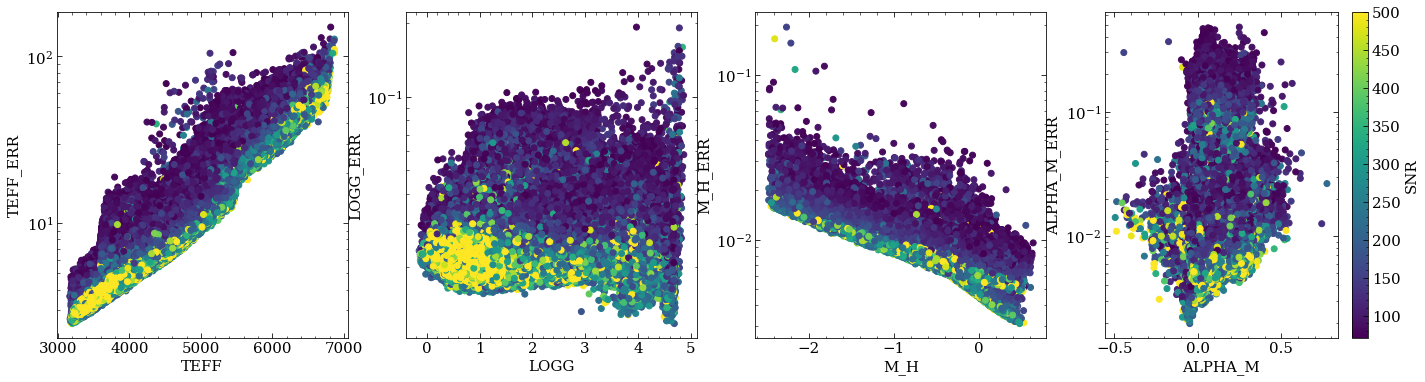

In [34]:
norm = colors.Normalize(70, 500)
mappable = matplotlib.cm.ScalarMappable(norm)
def quickerrplot(ax, label, range, logx = False, logy=False, cutval = None):
    ax.scatter(stars[label], stars[label + '_ERR'], c = stars['SNR'], norm = norm)
    if logx:
        ax.set_xscale('log')
    if logy:
        ax.set_yscale('log')
    ax.set_xlabel(label)
    ax.set_ylabel(label + '_ERR')
    # ax.plot(ax.get_xlim(), (cutval, cutval), linestyle = 'dashed', color = 'r')

fig, axs = plt.subplots(ncols = 4, figsize = (24, 6))
quickerrplot(axs[0], 'TEFF', (0, 1000), False, True, None)
quickerrplot(axs[1], 'LOGG', (0, 1), False, True, 0.2)
quickerrplot(axs[2], 'M_H', (0, 0.6), False, True, 0.5)
quickerrplot(axs[3], 'ALPHA_M', (0, 0.6), False, True, 0.5)
fig.colorbar(mappable, label = 'SNR')
plt.show()

In [87]:
### Spectra File Utilities ###
def getaspcappath(row):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TELESCOPE}/{FIELD}/'
    specname = 'aspcapStar-dr17-{SOURCEID}.fits'
    telescope = np.array(row['TELESCOPE'], dtype = str)
    field = np.array(row['FIELD'], dtype = str)
    sourceid = np.array(row['APOGEE_ID'], dtype = str)
#     length = len(sourceid)
    path = (specdir + specname).format(TELESCOPE = telescope, FIELD = field, SOURCEID = sourceid)
    return path

# tool for getting the path of apStar/asStar spectra from an ASPCAP hdulist
def getapstarpath(hdulist):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/redux/dr17/stars/{TELESCOPE}/{FIELD}/'
    telescope = str(hdulist[4].data['TELESCOPE'][0])
    field = str(hdulist[4].data['FIELD'][0])
    fname = str(hdulist[4].data['FILE'][0])
    path = ((specdir + fname).format(TELESCOPE = telescope, FIELD = field))
    return path

def get_aspcap_path(telescope = None, field = None, sourceid = None, row = None):
    if row is not None:
        telescope, field, sourceid = (np.array(row['TELESCOPE'], dtype = str), np.array(row['FIELD'], dtype = str), 
                                      np.array(row['APOGEE_ID'], dtype = str))
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TELESCOPE}/{FIELD}/'
    specname = 'aspcapStar-dr17-{SOURCEID}.fits'
    path = (specdir + specname).format(TELESCOPE = telescope, FIELD = field, SOURCEID = sourceid)
    return path

def get_apstar_path(telescope = None, field = None, fname = None, hdul = None):
    if hdul is not None:
        telescope, field, fname = (str(hdulist[4].data['TELESCOPE'][0]),str(hdulist[4].data['FIELD'][0]),str(hdulist[4].data['FILE'][0]))
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/redux/dr17/stars/{TELESCOPE}/{FIELD}/'
    path = (specdir + fname).format(TELESCOPE = telescope, FIELD = field, SOURCEID = sourceid)
    return path
    

wavs = np.power(10, 4.179 + 6e-06 * np.arange(8575)) 

In [6]:
def get_selected_stars(tab, teff_bin, logg_bin, m_h_bin return_indices = True):
    with np.errstate(divide='ignore', invalid = 'ignore'):
        indices = np.where((tab['TEFF'] >= teff_bin[0]) & (tab['TEFF'] < teff_bin[1]) & 
                            (tab['LOGG'] >= logg_bin[0]) & (tab['LOGG'] < logg_bin[1]) & 
                            (tab['M_H'] >= m_h_bin[0]) & (tab['M_H'] < m_h_bin[1]))[0]
    if return_indices:
        return indices
    else:
        return tab[indices]

In [98]:
teff_bins = np.concatenate([np.arange(3000, 5000, 50), np.arange(5000,10000, 150), [10000]])
logg_bins = np.around(np.arange(-1, 5.2, 0.2), 2)
m_h_bins = np.around(np.concatenate([np.arange(-2.3, -1.1, 0.3), np.arange(-1.1, 0.5, 0.2), [0.5]]), 2)

print(teff_bins)
print(logg_bins)
print(m_h_bins)

[ 3000  3050  3100  3150  3200  3250  3300  3350  3400  3450  3500  3550
  3600  3650  3700  3750  3800  3850  3900  3950  4000  4050  4100  4150
  4200  4250  4300  4350  4400  4450  4500  4550  4600  4650  4700  4750
  4800  4850  4900  4950  5000  5150  5300  5450  5600  5750  5900  6050
  6200  6350  6500  6650  6800  6950  7100  7250  7400  7550  7700  7850
  8000  8150  8300  8450  8600  8750  8900  9050  9200  9350  9500  9650
  9800  9950 10000]
[-1.  -0.8 -0.6 -0.4 -0.2 -0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6
  1.8  2.   2.2  2.4  2.6  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4
  4.6  4.8  5. ]
[-2.3 -2.  -1.7 -1.4 -1.1 -0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5]


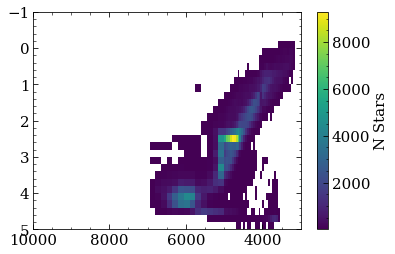

In [24]:
fig, ax = plt.subplots()
h = ax.hist2d(stars['TEFF'], stars['LOGG'], bins = (teff_bins, logg_bins), cmin = 1)
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymax, ymin)
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmax, xmin)
fig.colorbar(h[-1], label = "N Stars")
plt.show()

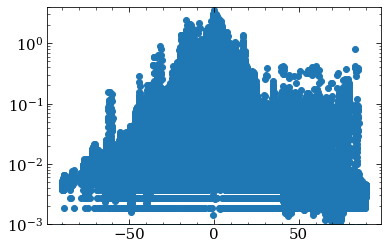

In [33]:
fig, ax = plt.subplots()
ax.scatter(stars['GLAT'], stars['AK_TARG'])
ax.set_yscale('log')
ax.set_ylim(0.001, 4)
plt.show()

In [90]:
# def get_star(star):
#     with fits.open(getaspcappath(star)) as aspcap:
#         aspcap = fits.open(getaspcappath(star))
#         spectrum = aspcap[1].data
#         error = aspcap[2].data
#         model = aspcap[3].data
    
#         with fits.open(getapstarpath(aspcap)) as apstar:
#             mask = apstar[3].data[0, :]
#             sky = apstar[4].data[0, :]
#             apstar.close()

#     return spectrum, error, model, mask, sky

def get_star(star):
    telescope, field, id, fname = (star['TELESCOPE'], star['FIELD'], star['APOGEE_ID'], star['FILE'])
    with fits.open(get_aspcap_path(telescope, field, id)) as aspcap:
        aspcap = fits.open(getaspcappath(star))
        spectrum = aspcap[1].data
        error = aspcap[2].data
        model = aspcap[3].data
        print(aspcap[4].data['FILE'])
    
    with fits.open(get_apstar_path(telescope, field, fname)) as apstar:
        mask = apstar[3].data[0, :]
        sky = apstar[4].data[0, :]
        apstar.close()
    return spectrum, error, model, mask, sky


In [96]:
def create_mask(bitmask, flags = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], skipflags = [10, 11]):
    # https://www.sdss.org/dr14/algorithms/bitmasks/#APOGEE_PIXMASK
    if type(flags) is not list:
        flags = [flags]
    if type(skipflags) is not list:
        skipflags = [skipflags]

    mask = np.zeros(bitmask.shape)
    for i in flags:
        if i not in skipflags:
            mask[np.bitwise_and(bitmask, 2**i) == 2**i] = 1
    return mask

In [107]:
def generate_residual(teff_bin_bounds, logg_bin_bounds, m_h_bin_bounds, alpha_bin_bounds):
    bin_stars = get_selected_stars(stars, teff_bin_bounds, logg_bin_bounds, m_h_bin_bounds, return_indices=False)
    
    for star in bin_stars:
        spec, err, mod, bitmask, sky = get_star(star)

        mask = create_mask(bitmask)
        spec = ma.array(spec, mask = mask)

        with np.errstate(divide = 'ignore'):
            res = spec / mod

        fig, ax = plt.subplots()
        ax.plot(wavs, res)
        ax.set_xlim(15272 - 10, 15272 + 10)
        plt.show()
    
generate_residual((6200, 6350), (4.2, 4.4), (-0.1, 0.1), (-np.infty, np.infty))

['apStar-dr17-2M00095069+0016456.fits']


NameError: name 'fnames' is not defined

In [103]:
s

FILE,APOGEE_ID,TARGET_ID,APSTAR_ID,ASPCAP_ID,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,TARG_PMRA,TARG_PMDEC,TARG_PM_SRC,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SURVEY,PROGRAMNAME,NVISITS,SNR,SNREV,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CHI2,RV_CCFWHM,RV_AUTOFWHM,RV_FLAG,N_COMPONENTS,MEANFIB,SIGFIB,MIN_H,MAX_H,MIN_JK,MAX_JK,GAIAEDR3_SOURCE_ID,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PHOT_G_MEAN_MAG,GAIAEDR3_PHOT_BP_MEAN_MAG,GAIAEDR3_PHOT_RP_MEAN_MAG,GAIAEDR3_DR2_RADIAL_VELOCITY,GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR,GAIAEDR3_R_MED_GEO,GAIAEDR3_R_LO_GEO,GAIAEDR3_R_HI_GEO,GAIAEDR3_R_MED_PHOTOGEO,GAIAEDR3_R_LO_PHOTOGEO,GAIAEDR3_R_HI_PHOTOGEO,ASPCAP_GRID,FPARAM_GRID,CHI2_GRID,FPARAM,FPARAM_COV,ASPCAP_CHI2,PARAM,PARAM_COV,PARAMFLAG,ASPCAPFLAG,ASPCAPFLAGS,FRAC_BADPIX,FRAC_LOWSNR,FRAC_SIGSKY,FELEM,FELEM_ERR,X_H,X_H_ERR,X_M,X_M_ERR,ELEM_CHI2,ELEMFRAC,ELEMFLAG,EXTRATARG,MEMBERFLAG,MEMBER,X_H_SPEC,X_M_SPEC,TEFF,TEFF_ERR,LOGG,LOGG_ERR,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,VMICRO,VMACRO,VSINI,TEFF_SPEC,LOGG_SPEC,C_FE,C_FE_SPEC,C_FE_ERR,C_FE_FLAG,CI_FE,CI_FE_SPEC,CI_FE_ERR,CI_FE_FLAG,N_FE,N_FE_SPEC,N_FE_ERR,N_FE_FLAG,O_FE,O_FE_SPEC,O_FE_ERR,O_FE_FLAG,NA_FE,NA_FE_SPEC,NA_FE_ERR,NA_FE_FLAG,MG_FE,MG_FE_SPEC,MG_FE_ERR,MG_FE_FLAG,AL_FE,AL_FE_SPEC,AL_FE_ERR,AL_FE_FLAG,SI_FE,SI_FE_SPEC,SI_FE_ERR,SI_FE_FLAG,P_FE,P_FE_SPEC,P_FE_ERR,P_FE_FLAG,S_FE,S_FE_SPEC,S_FE_ERR,S_FE_FLAG,K_FE,K_FE_SPEC,K_FE_ERR,K_FE_FLAG,CA_FE,CA_FE_SPEC,CA_FE_ERR,CA_FE_FLAG,TI_FE,TI_FE_SPEC,TI_FE_ERR,TI_FE_FLAG,TIII_FE,TIII_FE_SPEC,TIII_FE_ERR,TIII_FE_FLAG,V_FE,V_FE_SPEC,V_FE_ERR,V_FE_FLAG,CR_FE,CR_FE_SPEC,CR_FE_ERR,CR_FE_FLAG,MN_FE,MN_FE_SPEC,MN_FE_ERR,MN_FE_FLAG,FE_H,FE_H_SPEC,FE_H_ERR,FE_H_FLAG,CO_FE,CO_FE_SPEC,CO_FE_ERR,CO_FE_FLAG,NI_FE,NI_FE_SPEC,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,YB_FE,YB_FE_SPEC,YB_FE_ERR,YB_FE_FLAG,VISIT_PK,AV,DIB_AMPLITUDE
bytes64,bytes30,bytes58,bytes71,bytes77,bytes6,int32,bytes20,bytes30,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,bytes16,float32,bytes32,float32,float32,int32,int32,int32,int32,int32,int32,bytes132,bytes32,bytes32,int32,float32,float32,int64,bytes132,int64,bytes132,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,"float32[21,9]",float32[21],float32[9],"float32[9,9]",float32,float32[9],"float32[9,9]",int64[9],int64,bytes256,float32,float32,float32,float32[27],float64[27],float32[27],float32[27],float32[27],float32[27],float32[27],float32[27],int64[27],int32,int64,bytes10,float32[27],float32[27],float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float

In [7]:
# errs_cut = ((stars['TEFF_ERR'] / stars['TEFF'] < 0.1) & (stars['LOGG_ERR'] < 0.2) & (stars['M_H_ERR'] < 0.5) & (stars['ALPHA_M_ERR'] < 0.5))
# stars_cut = stars[errs_cut]

# norm = colors.Normalize(70, 500)
# mappable = matplotlib.cm.ScalarMappable(norm)
# def quickerrplot_cut(ax, label, logx = False, logy=False, cutval = None):
#     ax.scatter(stars_cut[label], stars_cut[label + '_ERR'], c = stars_cut['SNR'], norm = norm)
#     if logx:
#         ax.set_xscale('log')
#     if logy:
#         ax.set_yscale('log')
#     ax.set_xlabel(label)
#     ax.set_ylabel(label + '_ERR')
#     ax.plot(ax.get_xlim(), (cutval, cutval), linestyle = 'dashed', color = 'r')

# fig, axs = plt.subplots(ncols = 4, figsize = (24, 6))
# quickerrplot_cut(axs[0], 'TEFF', False, True, 600)
# quickerrplot_cut(axs[1], 'LOGG', False, True, 0.2)
# quickerrplot_cut(axs[2], 'M_H', False, True, 0.1)
# quickerrplot_cut(axs[3], 'ALPHA_M',  False, True, 0.2)
# fig.colorbar(mappable)
# plt.show()



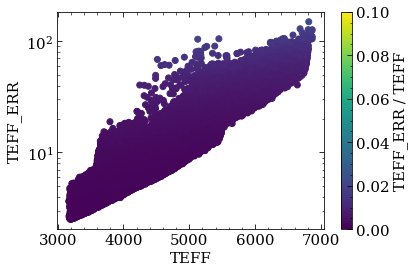

In [8]:
fig, ax = plt.subplots()
norm = colors.Normalize(0, 0.1)
points= ax.scatter(stars['TEFF'], stars['TEFF_ERR'], c = stars['TEFF_ERR'] / stars['TEFF'], norm = norm)
ax.set_yscale('log')
ax.set_xlabel('TEFF')
ax.set_ylabel('TEFF_ERR')
fig.colorbar(points, label = 'TEFF_ERR / TEFF')

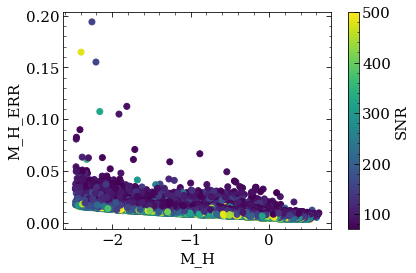

In [9]:
fig, ax = plt.subplots()
norm = colors.Normalize(70, 500)
points= ax.scatter(stars['M_H'], stars['M_H_ERR'], c = stars['SNR'], norm = norm)
# ax.set_yscale('log')
ax.set_xlabel('M_H')
ax.set_ylabel('M_H_ERR')
fig.colorbar(points, label = 'SNR')

In [10]:
Av = 3.1 / 0.302 * stars['AK_TARG']
sigma0 = 2.0
DIB_amp = 102e-3 * Av / (np.sqrt(2 * np.pi) * sigma0)


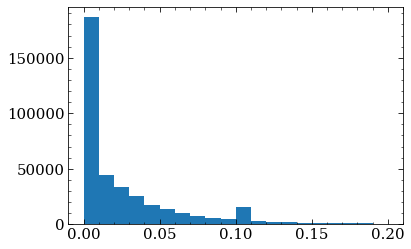

In [11]:
plt.hist(DIB_amp, range = (0,0.2), bins = 20)
plt.show()

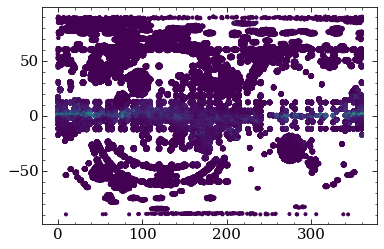

In [12]:
plt.scatter(stars["GLON"], stars['GLAT'], c = stars['AK_TARG'], marker = '.', vmin = 0, vmax = 3)

(array([3.46543e+05, 3.26370e+04, 6.14700e+03, 8.23000e+02, 1.91000e+02,
        9.90000e+01, 4.20000e+01, 1.40000e+01, 1.00000e+01, 5.00000e+00]),
 array([  70.00059,  472.55878,  875.11694, 1277.6752 , 1680.2334 ,
        2082.7915 , 2485.3499 , 2887.908  , 3290.466  , 3693.0244 ,
        4095.5825 ], dtype=float32),
 <BarContainer object of 10 artists>)

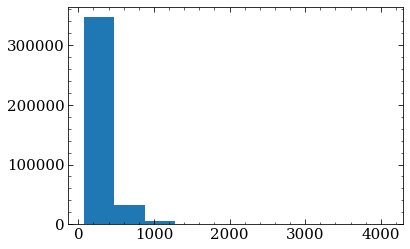

In [13]:
plt.hist(stars['SNR'])

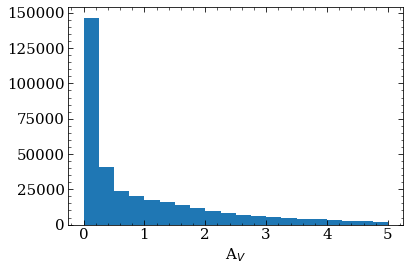

In [14]:
plt.hist(Av, range = (0,5), bins = 20)
plt.xlabel('A$_V$')
plt.show()